## Visualize Linear Model Power Analysis

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

In [2]:
output_power_figure <- file.path("figures", "power_analysis_cp_lm.png")

In [3]:
# Load linear modeling results
lm_results_file <- file.path("results", "linear_model_cp_features.tsv")
lm_results_df <- readr::read_tsv(
    lm_results_file,
    col_types = readr::cols(.default="d", feature="c")
)

# Load linear modeling power
lm_power_file <- file.path("results", "power_analysis_cp_features_lm.tsv")
lm_power_df <- readr::read_tsv(
    lm_power_file,
    col_types = readr::cols(.default="d", feature="c")
)

# Merge for visualization
lm_data_df <- lm_results_df %>%
    dplyr::left_join(lm_power_df, by = "feature") %>%
    dplyr::arrange(estimated_sample_size) %>%
    dplyr::filter(estimated_sample_size < 100000) %>%  # Remove extreme outlier
    dplyr::filter(!is.na(power))

print(dim(lm_data_df))
head(lm_data_df)

Warning message:
“One or more parsing issues, call `problems()` on
your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”


[1] 1009   10


feature,r2_score,cell_count_coef,Null_coef,WT_coef,u,v,sig_level,power,estimated_sample_size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cells_Intensity_StdIntensity_DAPI,0.6574328,0.05403655,-0.1791111,0.1791111,1,147,4.793864e-05,0.8,20.62342
Nuclei_Intensity_MedianIntensity_DAPI,0.6509686,0.05893377,-0.3619834,0.3619834,1,147,4.793864e-05,0.8,20.99464
Cytoplasm_Intensity_LowerQuartileIntensity_DAPI,0.6356989,0.06495136,-0.6843496,0.6843496,1,147,4.793864e-05,0.8,21.89979
Cytoplasm_Intensity_MinIntensity_DAPI,0.6225846,0.06400826,-0.6595804,0.6595804,1,147,4.793864e-05,0.8,22.71079
Cells_Intensity_MinIntensity_DAPI,0.6225846,0.06400826,-0.6595804,0.6595804,1,147,4.793864e-05,0.8,22.71079
Cytoplasm_Intensity_MinIntensityEdge_DAPI,0.5980773,0.06429350,-0.7653787,0.7653787,1,147,4.793864e-05,0.8,24.31758


In [4]:
# Load feature data (for current n)
data_dir <-file.path("..", "..", "..", "4_processing_features", "data")
cp_file <- file.path(data_dir, "nf1_sc_norm_cellprofiler.csv.gz")

cp_df <- readr::read_csv(
    cp_file,
    col_types = readr::cols(
        .default="d",
        Metadata_WellRow="c",
        Metadata_WellCol="c",
        Metadata_Well="c",
        Metadata_gene_name="c",
        Metadata_genotype="c"
    )
)

n_samples <- dim(cp_df)[1]

print(dim(cp_df))
head(cp_df, 3)

New names:
• `` -> `...1`


[1]  149 1056


...1,Metadata_WellRow,Metadata_WellCol,Metadata_number_of_singlecells,Metadata_gene_name,Metadata_genotype,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cytoplasm_Parent_Cells,⋯,Nuclei_Texture_SumVariance_RFP_3_02_256,Nuclei_Texture_SumVariance_RFP_3_03_256,Nuclei_Texture_Variance_GFP_3_00_256,Nuclei_Texture_Variance_GFP_3_01_256,Nuclei_Texture_Variance_GFP_3_02_256,Nuclei_Texture_Variance_GFP_3_03_256,Nuclei_Texture_Variance_RFP_3_00_256,Nuclei_Texture_Variance_RFP_3_01_256,Nuclei_Texture_Variance_RFP_3_02_256,Nuclei_Texture_Variance_RFP_3_03_256
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,C,6,12,NF1,WT,1,1,C6,1,⋯,3.1415403,3.2022729,-0.09735552,-0.096165089,-0.09420230,-0.10645635,3.3379688,3.3505284,3.2781681,3.3103705
1,C,6,12,NF1,WT,1,1,C6,2,⋯,0.3159240,0.2586328,-0.08797075,-0.069492845,-0.06553894,-0.09537677,0.3147762,0.3139198,0.3484196,0.3186928
2,C,6,12,NF1,WT,1,1,C6,3,⋯,0.2952335,0.3831610,0.06525064,0.005549586,-0.01521187,-0.02908654,0.3484921,0.3339402,0.3413119,0.3479994


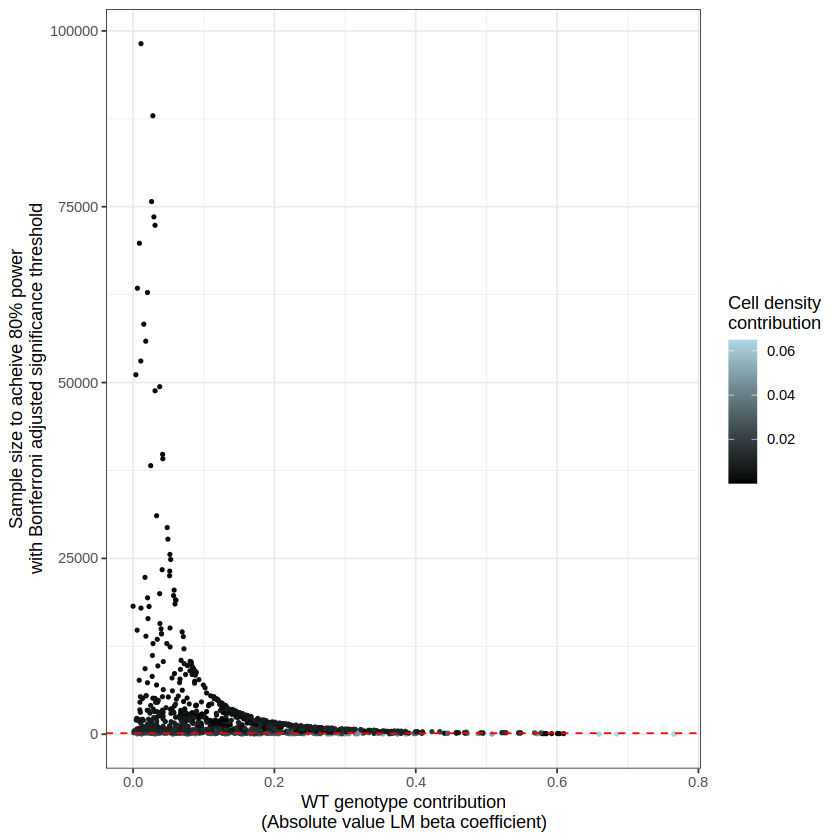

In [5]:
power_gg <- (
    ggplot(lm_data_df, aes(y = estimated_sample_size, x = abs(WT_coef)))
    + geom_point(aes(color = abs(cell_count_coef)), size = 0.8)
    + theme_bw()
    + xlab("WT genotype contribution\n(Absolute value LM beta coefficient)")
    + ylab("Sample size to acheive 80% power\nwith Bonferroni adjusted significance threshold")
    + geom_hline(yintercept = n_samples, linetype = "dashed", color = "red")
    + scale_color_gradient(name = "Cell density\ncontribution", low = "black", high = "lightblue")
)

power_gg

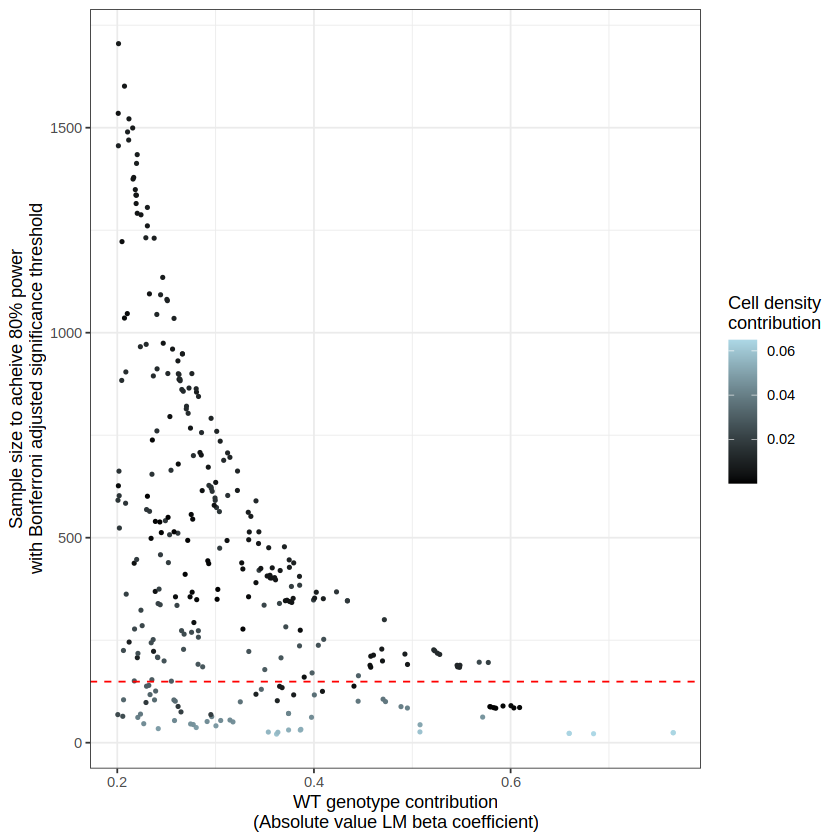

In [6]:
power_zoom_gg <- (
    ggplot(
        lm_data_df %>% dplyr::filter(abs(WT_coef) > 0.2),
        aes(y = estimated_sample_size, x = abs(WT_coef))
    )
    + geom_point(aes(color = abs(cell_count_coef)), size = 0.8)
    + theme_bw()
    + geom_hline(yintercept = n_samples, linetype = "dashed", color = "red")
    + xlab("WT genotype contribution\n(Absolute value LM beta coefficient)")
    + ylab("Sample size to acheive 80% power\nwith Bonferroni adjusted significance threshold")
    + scale_color_gradient(name = "Cell density\ncontribution", low = "black", high = "lightblue")
)

power_zoom_gg

In [7]:
full_power_gg <- power_gg + power_zoom_gg
ggsave(output_power_figure, full_power_gg, dpi = 500, width = 13, height = 6)